In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report 

In [6]:
# --- Configuration ---
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
CLASS_NAMES = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Update these paths to your actual dataset location
BASE_PATH = r'C:\Users\Samsung\Downloads\modified-dataset'
TRAIN_PATH = f'{BASE_PATH}\\train'
TEST_PATH = f'{BASE_PATH}\\test'
VALID_PATH = f'{BASE_PATH}\\val'

In [7]:

# --- Data Loading ---
def load_dataset(path, shuffle=True, validation_split=False):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        shuffle=shuffle,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )

datatrain = load_dataset(TRAIN_PATH)
datatest = load_dataset(TEST_PATH, shuffle=False)
datavalid = load_dataset(VALID_PATH)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


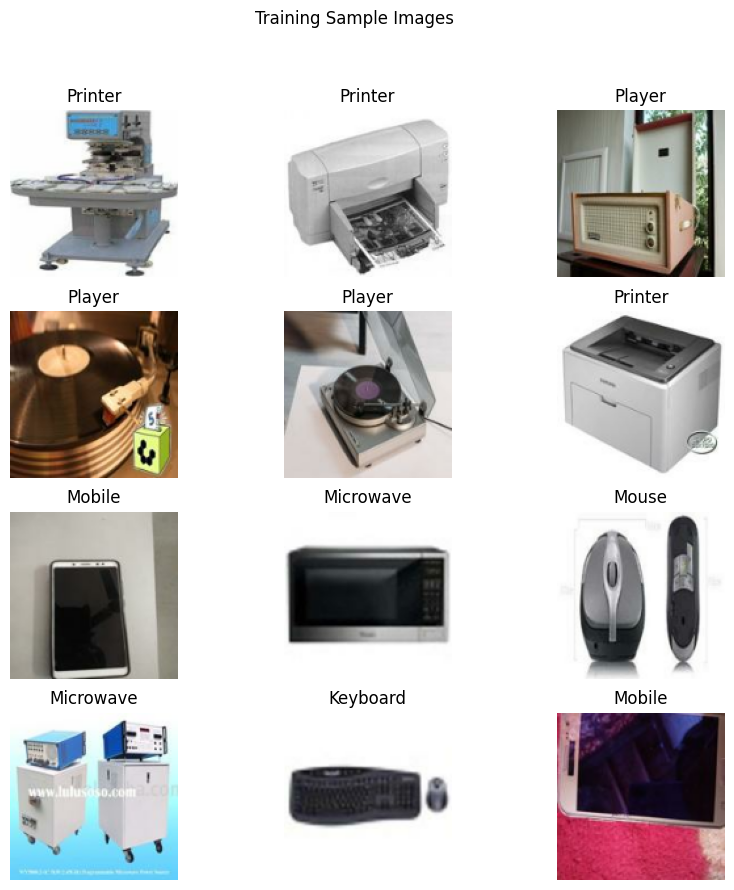

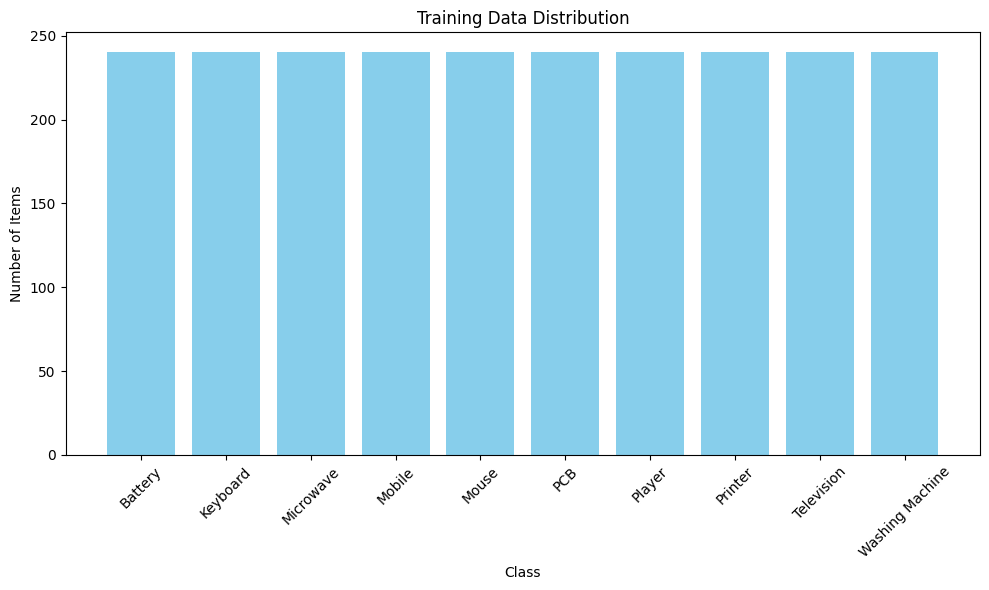

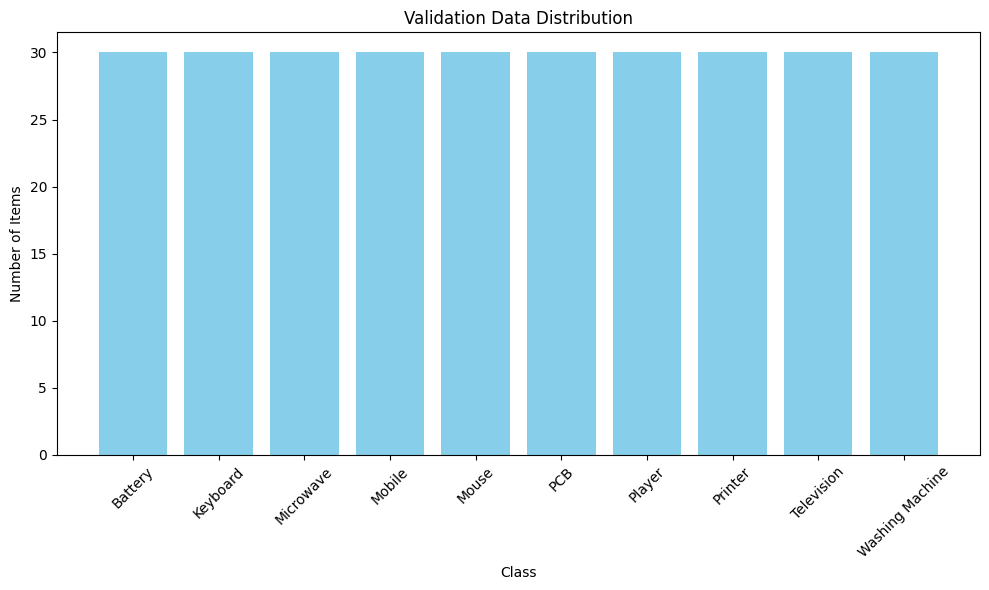

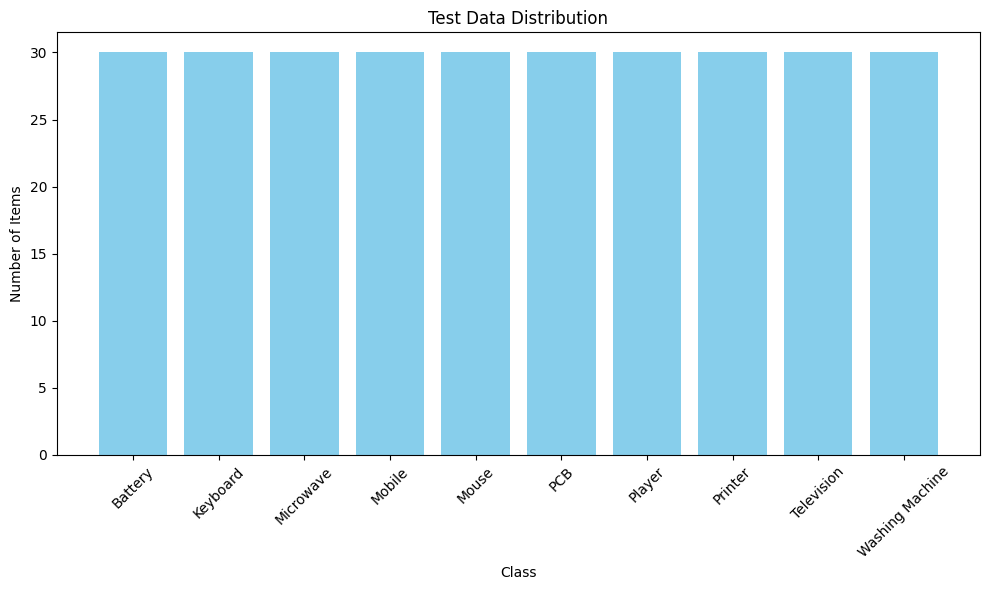

In [8]:

# --- Data Visualization and Distribution ---
def plot_samples(dataset, title="Sample Images"):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(12, len(images))):
            ax = plt.subplot(4, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASS_NAMES[labels[i]])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

def plot_class_distribution(dataset, title="Class Distribution"):
    class_counts = {name: 0 for name in CLASS_NAMES}
    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[CLASS_NAMES[label]] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_samples(datatrain, "Training Sample Images")
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [9]:

# --- Model Definition ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True # Ensure base model layers are trainable by default
# Freeze initial layers (e.g., first 100 layers)
for layer in base_model.layers[:100]:
    layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['Accuracy']
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 63s 3us/step


In [10]:

# --- Model Training ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 15
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - Accuracy: 0.2710 - loss: 2.1035 - val_Accuracy: 0.7933 - val_loss: 1.1015
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - Accuracy: 0.7575 - loss: 1.0019 - val_Accuracy: 0.9100 - val_loss: 0.4890
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - Accuracy: 0.8680 - loss: 0.5069 - val_Accuracy: 0.9333 - val_loss: 0.3004
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - Accuracy: 0.9080 - loss: 0.3509 - val_Accuracy: 0.9467 - val_loss: 0.2194
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - Accuracy: 0.9312 - loss: 0.2603 - val_Accuracy: 0.9400 - val_loss: 0.1954
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - Accuracy: 0.9570 - loss: 0.1822 - val_Accuracy: 0.9633 - val_loss: 0.1599
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - Accuracy: 0.9460 - loss: 0.1680 - val_Accuracy: 0.9633 - val_loss: 0.1607
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - Accuracy: 0.9681 - loss: 0.1287 - val_Accuracy: 0.9633 - v

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

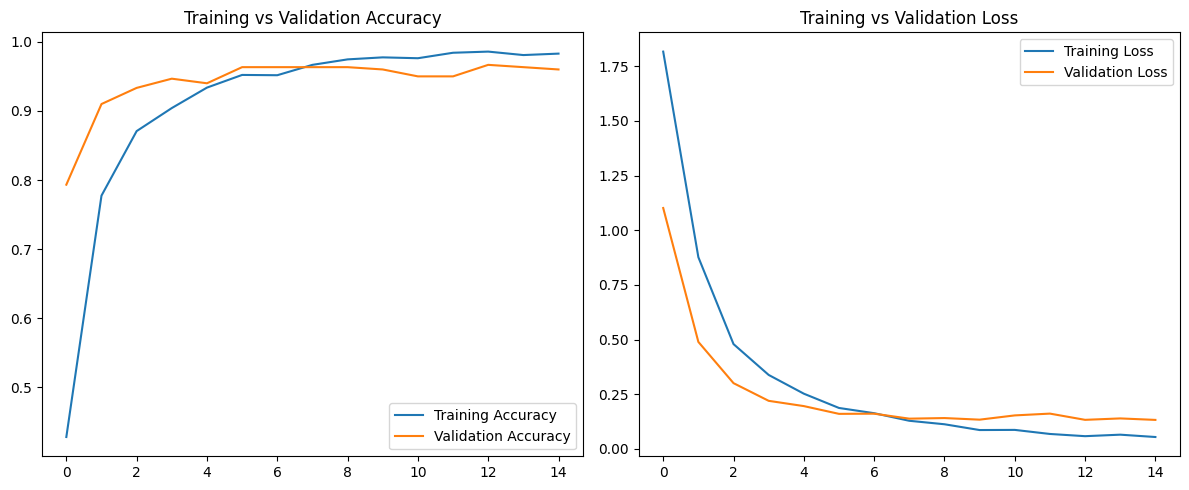

In [11]:

# --- Model Summary and Performance Visualization ---
model.summary()

def plot_performance(history):
    acc = history.history['Accuracy']
    val_acc = history.history['val_Accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')
    plt.tight_layout()
    plt.show()

plot_performance(history)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - Accuracy: 0.9479 - loss: 0.1679
Test Accuracy: 0.9467, Test Loss: 0.1497
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 

Confusion Matrix:
 [[28  0  0  0  0  1  0  0  0  1]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 28  0  1  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 4  0  1  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  1 29  0  0]
 [ 0  0  1  0  0  0  1  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]

Classification Report:
                  precision    recall  f1-score   support

        Battery       0.85      0.93      0.89        30
       Keyboard       1.00      0.97      0.98        30
      Microwave       0.94      0.97      0.95        30
         Mobile       1.00      0.97      0.98        30
          Mouse       1.00      0.93      0.97        30
            PCB       0.94      0.97      0.95        30
         Player       0.86      0.83      0.85        30
        Pri

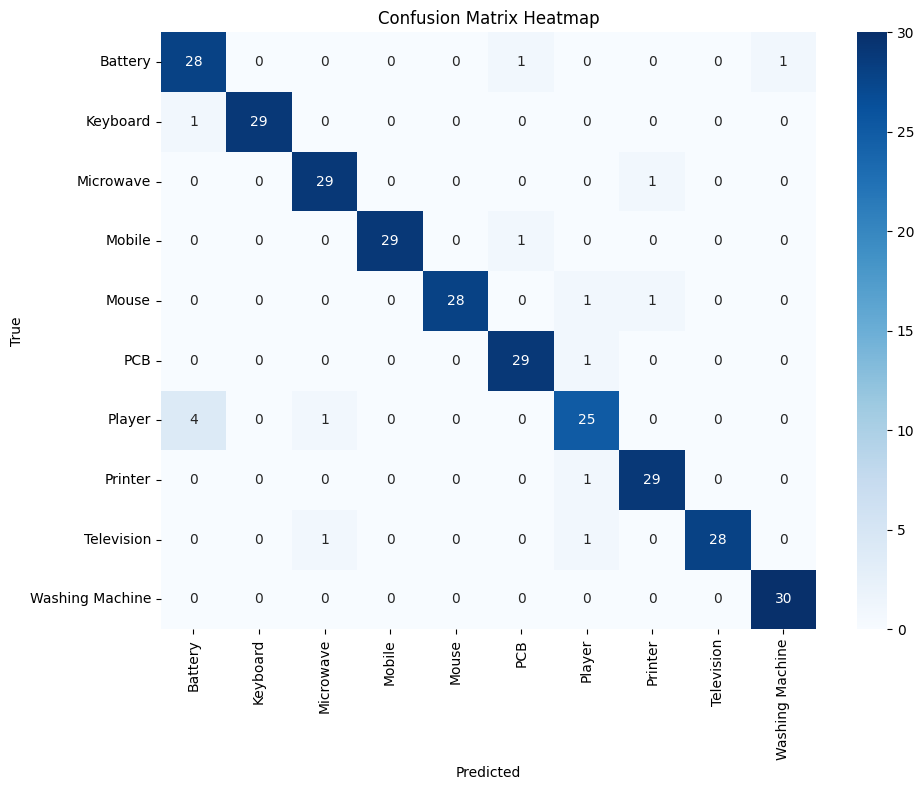

In [12]:

# --- Model Evaluation ---
loss, accuracy = model.evaluate(datatest)
print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}')

y_true = np.concatenate([y.numpy() for _, y in datatest], axis=0)
y_pred_probs = model.predict(datatest)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=CLASS_NAMES))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


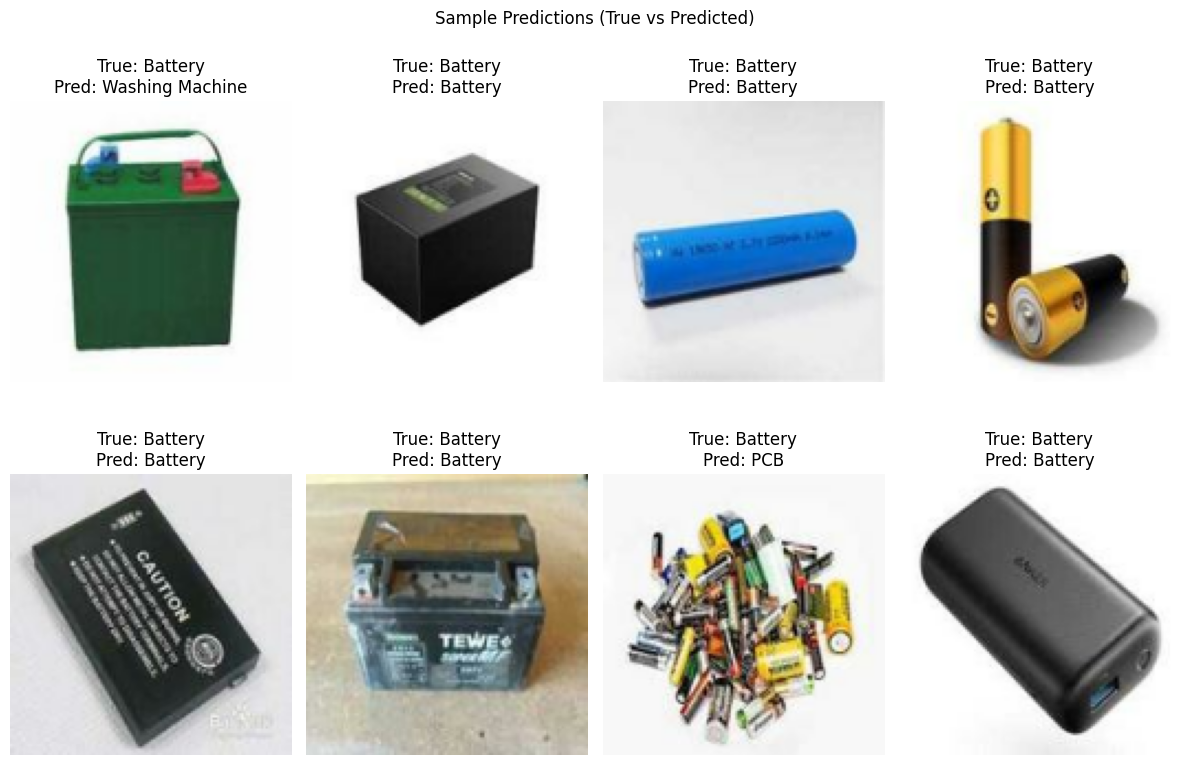

In [13]:

# --- Sample Predictions Display ---
for images, labels in datatest.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {CLASS_NAMES[labels[i]]}\nPred: {CLASS_NAMES[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.suptitle("Sample Predictions (True vs Predicted)", y=1.02)
    plt.show()

In [14]:

# --- Save Model ---
model.save('Efficient_classify.keras')
print("\nModel saved as 'Efficient_classify.keras'")


Model saved as 'Efficient_classify.keras'


In [15]:

# --- Gradio Deployment ---
# Ensure you have Gradio installed: !pip install gradio

# Load the saved model (if running in a new session)
# model = tf.keras.models.load_model('Efficient_classify.keras')

def classify_image(img):
    img = img.resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = CLASS_NAMES[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="E-Waste Image Classification",
    description="Upload an image of e-waste to classify it into one of 10 categories."
)

iface.launch(inbrowser=True)
print("\nGradio interface launched.")

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.



Gradio interface launched.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
